In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [6]:
df = pd.read_csv('tmdb_5000_movies.csv')


In [7]:
x = df.iloc[0]
x

,0
budget,237000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/
id,19995
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":..."
original_language,en
original_title,Avatar
overview,"In the 22nd century, a paraplegic Marine is di..."
popularity,150.437577
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289..."


In [8]:
x['genres']

'[{"id": 28, "name": "Action"}, {"id": 12, "name": "Adventure"}, {"id": 14, "name": "Fantasy"}, {"id": 878, "name": "Science Fiction"}]'

In [9]:
x['keywords']

'[{"id": 1463, "name": "culture clash"}, {"id": 2964, "name": "future"}, {"id": 3386, "name": "space war"}, {"id": 3388, "name": "space colony"}, {"id": 3679, "name": "society"}, {"id": 3801, "name": "space travel"}, {"id": 9685, "name": "futuristic"}, {"id": 9840, "name": "romance"}, {"id": 9882, "name": "space"}, {"id": 9951, "name": "alien"}, {"id": 10148, "name": "tribe"}, {"id": 10158, "name": "alien planet"}, {"id": 10987, "name": "cgi"}, {"id": 11399, "name": "marine"}, {"id": 13065, "name": "soldier"}, {"id": 14643, "name": "battle"}, {"id": 14720, "name": "love affair"}, {"id": 165431, "name": "anti war"}, {"id": 193554, "name": "power relations"}, {"id": 206690, "name": "mind and soul"}, {"id": 209714, "name": "3d"}]'

In [10]:
j = json.loads(x['genres'])
' '.join(''.join(jj['name'].split()) for jj in j)


'Action Adventure Fantasy ScienceFiction'

In [11]:
# convert the relevant data for each movie into a single string
# to be ingested by TfidfVectorizer
def genres_and_keywords_to_string(row):
  genres = json.loads(row['genres'])
  genres = ' '.join(''.join(j['name'].split()) for j in genres)

  keywords = json.loads(row['keywords'])
  keywords = ' '.join(''.join(j['name'].split()) for j in keywords)
  return "%s %s" % (genres, keywords)

In [12]:
# create a new string representation of each movie
df['string'] = df.apply(genres_and_keywords_to_string, axis=1)
# create a tf-idf vectorizer object
tfidf = TfidfVectorizer(max_features=2000)
# create a data matrix from the overviews
X = tfidf.fit_transform(df['string'])
X
# generate a mapping from movie title -> index (in df)
movie2idx = pd.Series(df.index, index=df['title'])
movie2idx
idx = movie2idx['Scream 3']
idx

np.int64(1164)

In [13]:
query = X[idx]
query

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9 stored elements and shape (1, 2000)>

In [14]:
# print the query vector
query.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

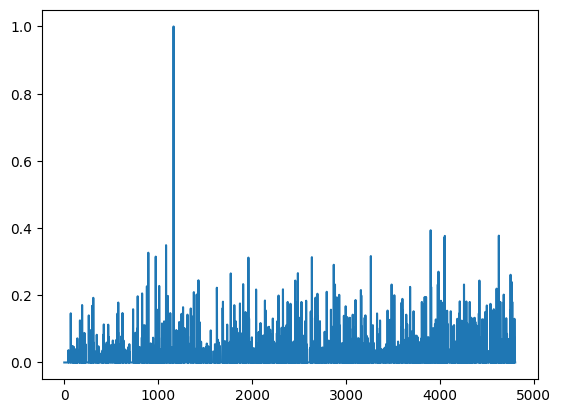

In [15]:
# compute similarity between query and every vector in X
scores = cosine_similarity(query, X)
# currently the array is 1 x N, make it just a 1-D array
scores = scores.flatten()
plt.plot(scores)


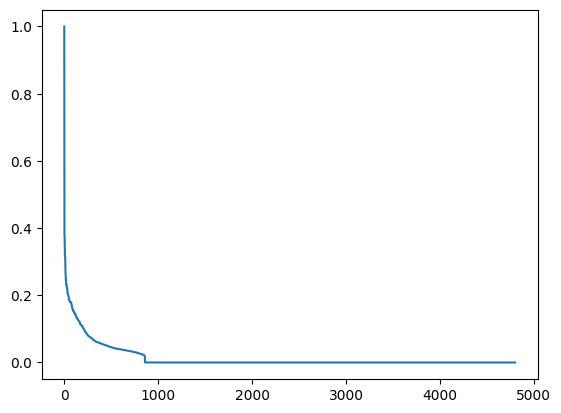

In [16]:
(-scores).argsort()
plt.plot(scores[(-scores).argsort()]);


In [17]:
# get top 5 matches
# exclude self (similarity between query and itself yields max score)
recommended_idx = (-scores).argsort()[1:6]

In [18]:
# convert indices back to titles
df['title'].iloc[recommended_idx]

,title
3902,Friday the 13th Part VI: Jason Lives
4628,Graduation Day
4053,Friday the 13th: A New Beginning
4048,The Calling
1084,The Glimmer Man


In [19]:
# create a function that generates recommendations
def recommend(title):
  # get the row in the dataframe for this movie
  idx = movie2idx[title]
  if type(idx) == pd.Series:
    idx = idx.iloc[0]

  # calculate the pairwise similarities for this movie
  query = X[idx]
  scores = cosine_similarity(query, X)

  # currently the array is 1 x N, make it just a 1-D array
  scores = scores.flatten()

  # get the indexes of the highest scoring movies
  # get the first K recommendations
  # don't return itself!
  recommended_idx = (-scores).argsort()[1:6]

  # return the titles of the recommendations
  return df['title'].iloc[recommended_idx]

In [20]:
print("Recommendations for 'Scream 3':")
print(recommend('Scream 3'))

Recommendations for 'Scream 3':
3902    Friday the 13th Part VI: Jason Lives
4628                          Graduation Day
4053        Friday the 13th: A New Beginning
4048                             The Calling
1084                         The Glimmer Man
Name: title, dtype: object
